In [68]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Embedding, Input, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt

In [2]:
merged_data = pd.read_csv('merged_data_with_predictions.csv')

In [3]:
merged_data.head()

,subject,body,label_email,predicted_class_email,predicted_class_encoded_email,correct_prediction_email,url_id,URL,label_url,url_len,...,//,abnormal_url,https,digits,letters,Shortining_Service,having_ip_address,predicted_class_url,predicted_class_encoded_url,correct_prediction_url
0,free,this is a multi-part message in mime format . ...,1,Phishing Email,1,True,0,https://southbankmosaics.com,1,28,...,1,1,1,0,24,0,0,1,Phishing URL,True
1,the internet success toolbox,note : we do not wish to send e-mail to anyone...,1,Phishing Email,1,True,1,https://uni-mainz.de,1,20,...,1,1,1,0,15,0,0,1,Phishing URL,True
2,free stealth 3 . 0 bulk email software . . .,"just released . . . 30 , 000 , 000 email addre...",1,Phishing Email,1,True,2,https://voicefmradio.co.uk,1,26,...,1,1,1,0,21,0,0,1,Phishing URL,True
3,need more money ?,"hi , would you like to earn an extra $ 700 a w...",1,Phishing Email,1,True,3,https://sfnmjournal.com,1,23,...,1,1,1,0,19,0,0,1,Phishing URL,True
4,cable decsrambler now only $ 6 . 99 !,this is really cool ! premium channels and pay...,1,Phishing Email,1,True,4,https://rewildingargentina.org,1,30,...,1,1,1,0,26,0,0,1,Phishing URL,True


In [65]:
print(merged_data.isna().sum())

subject                          31
body                              0
label_email                       0
predicted_class_email             0
predicted_class_encoded_email     0
correct_prediction_email          0
url_id                            0
URL                               0
label_url                         0
url_len                           0
domain                            4
@                                 0
?                                 0
-                                 0
=                                 0
.                                 0
#                                 0
%                                 0
+                                 0
$                                 0
!                                 0
*                                 0
,                                 0
//                                0
abnormal_url                      0
https                             0
digits                            0
letters                     

In [67]:
merged_data.columns

Index(['subject', 'body', 'label_email', 'predicted_class_email',
       'predicted_class_encoded_email', 'correct_prediction_email', 'url_id',
       'URL', 'label_url', 'url_len', 'domain', '@', '?', '-', '=', '.', '#',
       '%', '+', '$', '!', '*', ',', '//', 'abnormal_url', 'https', 'digits',
       'letters', 'Shortining_Service', 'having_ip_address',
       'predicted_class_url', 'predicted_class_encoded_url',
       'correct_prediction_url'],
      dtype='object')

In [69]:
columns_to_drop = ['subject', 'body', 'url_id', 'URL', 'predicted_class_email', 'correct_prediction_email', 'label_url', 'correct_prediction_url', 'predicted_class_encoded_url', 'predicted_class_encoded_email']
# columns_to_encode = ['domain', '@', '?', '-', '=', '.', '#', '%', '+', '$', '!', '*', ',', '//', 'abnormal_url', 'https']
columns_to_encode = ['domain']

In [ ]:
# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('drop_columns', 'drop', columns_to_drop),
        ('encode_columns', OneHotEncoder(), columns_to_encode)
    ],
    remainder='passthrough'
)


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler())
])

In [5]:
X_email_data = pd.DataFrame()
X['subject_tokenized']= merged_data['subject'].fillna('').apply(lambda x: word_tokenize(x.lower()))
X['body_tokenized'] = merged_data['body'].apply(lambda x: word_tokenize(x.lower()))

In [6]:
X_url_features = pd.get_dummies(merged_data[['domain', '@', '?', '-', '=', '.', '#', '%', '+', '$', '!', '*', ',', '//', 'abnormal_url', 'https', 'digits', 'letters', 'Shortining_Service', 'having_ip_address']])
y = merged_data['label_email']

In [7]:
#removing stop words
stop_words = set(stopwords.words('english'))
X['body_tokenized'] = X['body_tokenized'].apply(lambda x: [word for word in x if word not in stop_words and word not in string.punctuation])

In [8]:
X.head()

,subject_tokenized,body_tokenized
0,[free],"[multi-part, message, mime, format, nextpart, ..."
1,"[the, internet, success, toolbox]","[note, wish, send, e-mail, anyone, want, pleas..."
2,"[free, stealth, 3, ., 0, bulk, email, software...","[released, 30, 000, 000, email, addresses, plu..."
3,"[need, more, money, ?]","[hi, would, like, earn, extra, 700, week, 2, 8..."
4,"[cable, decsrambler, now, only, $, 6, ., 99, !]","[really, cool, premium, channels, pay, per, vi..."


In [36]:
X_url_features.head()

,@,?,-,=,.,#,%,+,$,!,...,domain_ytv.co.jp,domain_yzxlsc.com,domain_z9a7yo.webwave.dev,domain_zadar.hr,domain_zellepay9-1211c.firebaseapp.com,domain_zelmao.ga,domain_zomoplus.store,domain_zrg34-f955e.firebaseapp.com,domain_zurbrioerf.com,domain_zxporter.com
0,0,0,0,0,1,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,0,0,1,0,1,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,0,0,0,0,2,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,0,0,0,0,1,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,0,0,0,0,1,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False


In [71]:
X_url_features['digits']

0        0
1        0
2        0
3        0
4        0
        ..
1008    13
1009     0
1010     4
1011     9
1012     0
Name: digits, Length: 1013, dtype: int64

In [23]:
print(X.shape)
print(X_url_features.shape)

(1013, 2)
(1013, 1008)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_url_train, X_url_test, y_url_train, y_url_test = train_test_split(X_url_features, y, test_size=0.2, random_state=42)


In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['body_tokenized'])

In [27]:
# converting the tokenized words to sequence
X_train_seq = tokenizer.texts_to_sequences(X_train['body_tokenized'])
X_test_seq = tokenizer.texts_to_sequences(X_test['body_tokenized'])

In [28]:
train_seq_length = [len(seq) for seq in X_train_seq]

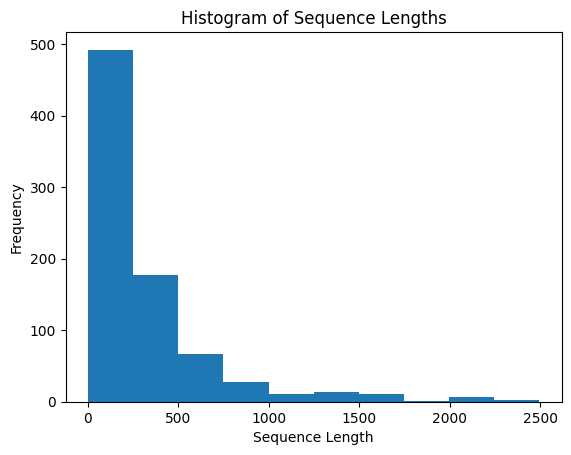

In [29]:
plt.hist(train_seq_length, bins=10)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Histogram of Sequence Lengths')
plt.show()

In [30]:
# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

In [40]:
X_train_pad

array([[ 1422,   774,   140, ...,    10, 10353,  6824],
       [  411,  1041,    89, ...,   293,  2176,  2293],
       [  494,   174,    49, ...,  5247, 15038, 15039],
       ...,
       [ 6786,  1349,   981, ...,  1842,     4,  3178],
       [ 7565,  5731, 12148, ..., 14931,  6554,   146],
       [    0,     0,     0, ...,  1337,    62,   318]])

In [31]:
# Using pre-trained GloVe embeddings to create an embedding matrix
embeddings_index = {}
with open('T:\MS in AI courses\Machine Learning\glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [32]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [61]:
# model = Sequential()
vocab_size = len(tokenizer.word_index) + 1
# embedding_dim = 100
# model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=100, trainable=False))
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))  # Binary classification
url_input = Input(shape=(X_url_features.shape[1],))

# Define the input for text features
embedding_dim = 100
text_input = Input(shape=(100,))
embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=100, trainable=False)
embedded_text = embedding_layer(text_input)
flattened_text = Flatten()(embedded_text)

# flatten_layer = Flatten()(embedding_layer)
concatenated_features = Concatenate()([flattened_text, url_input])

# Defining the model architecture
dense_layer = Dense(64, activation='relu')(concatenated_features)
output_layer = Dense(1, activation='sigmoid')(dense_layer)

# Creating the model
model = Model(inputs=[text_input, url_input], outputs=output_layer)

In [47]:
# model = Sequential([
#     Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
#     Dropout(0.2),
#     Dense(64, activation='relu'),
#     Dropout(0.2),
#     Dense(1, activation='sigmoid')
# ])

In [62]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [63]:
X_url_train_values_int32 = X_url_train.values.astype('int32')
X_url_test_values_int32 = X_url_test.values.astype('int32')
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')
print(X_train_pad.shape, X_train_pad.dtype, X_url_train_values_int32.shape, y_train.shape, y_train.dtype, X_test_pad.shape, X_test_pad.dtype, X_url_test_values_int32.shape, y_test.shape, y_test.dtype)
print(len(X_train_pad))

(810, 100) int32 (810, 1008) (810,) int32 (203, 100) int32 (203, 1008) (203,) int32
810


In [64]:
# tf.config.run_functions_eagerly(True)
model.fit([X_train_pad, X_url_train_values_int32], y_train, epochs=10, batch_size=32, validation_data=([X_test_pad, X_url_test_values_int32], y_test))

Epoch 1/10


c:\Users\toufic.f\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


26/26 [==============================] - 2s 75ms/step - loss: 0.2148 - accuracy: 0.8963 - val_loss: 0.2616 - val_accuracy: 0.9310
Epoch 2/10
26/26 [==============================] - 2s 77ms/step - loss: 0.0271 - accuracy: 0.9951 - val_loss: 0.1992 - val_accuracy: 0.9458
Epoch 3/10
26/26 [==============================] - 2s 73ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 0.2110 - val_accuracy: 0.9409
Epoch 4/10
26/26 [==============================] - 2s 75ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.2213 - val_accuracy: 0.9360
Epoch 5/10
26/26 [==============================] - 2s 76ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2234 - val_accuracy: 0.9360
Epoch 6/10
26/26 [==============================] - 2s 79ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2238 - val_accuracy: 0.9409
Epoch 7/10
26/26 [==============================] - 2s 78ms/step - loss: 8.2304e-04 - accuracy: 1.0000 - val_loss: 0.2258 - val_accuracy: 0.9409
Epoch 8/10
26/26 [==